In [457]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [458]:
import wandb
api = wandb.Api()

In [459]:
sweep_id = '0q6ri6st'
sweep = api.sweep(f"ogait/thesis_gravity_spy/{sweep_id}")

In [460]:
summary_list = [] 
config_list = [] 
name_list = [] 
for run in sweep.runs: 
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files 
    summary = {k:v for k,v in run.summary.items() if k in ('f1_score', 'total_runtime', 'combined_f1_time')}
    summary_list.append(summary) 

    # # run.config is the input metrics.
    # # We remove special values that start with _.
    config = {k:v for k,v in run.config.items() if k in ('architecture', 'epochs', 'frozen_epochs', 'suggest_func')}
    config_list.append(config) 

    # run.name is the name of the run.
    name_list.append(run.name)       

summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 
all_df = pd.concat([name_df, config_df,summary_df], axis=1)

In [461]:
all_df['time_epoch'] = all_df['total_runtime'] / (all_df['epochs'] + all_df['frozen_epochs'])

In [462]:
all_df.head()

,name,epochs,architecture,suggest_func,frozen_epochs,f1_score,combined_f1_time,total_runtime,time_epoch
0,morning-sweep-36,14,convnext_tiny,minimum,1,0.980437,0.974784,169.610381,11.307359
1,vague-sweep-35,14,convnext_tiny,steep,1,0.970403,0.964532,176.135094,11.742340
2,crimson-sweep-34,9,convnext_tiny,minimum,1,0.974598,0.970758,115.223965,11.522396
3,woven-sweep-33,9,convnext_tiny,steep,1,0.976390,0.972598,113.750399,11.375040
4,iconic-sweep-32,4,convnext_tiny,minimum,1,0.975158,0.973099,61.764586,12.352917


In [463]:
def plot_compare(x_var, y_var, order=None, ylim=(0.9, 1)):
    ax = sns.barplot(x=x_var, y=y_var, data=all_df, errwidth=0, alpha=0.60, order=order)
    sns.stripplot(x=x_var, y=y_var,  data=all_df, linewidth=1, size=8, order=order)
    plt.xlabel(x_var, size='large')
    plt.ylabel(y_var, size='large')
    plt.ylim(ylim)
    return ax

In [464]:
import matplotlib.lines as mlines

def plot_compare_v2(x_var, y_var, order=None, ylim=(0.9, 1)):
    ax = sns.boxplot(x=x_var, y=y_var, data=all_df, order=order,
                     showmeans=True, meanprops={"marker": "+", "markeredgecolor": "black"})
    average = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
                          markersize=8, label='distribution average')
    ax.legend(handles=[average], loc='upper right')
    plt.xlabel(x_var, size='large')
    plt.ylabel(y_var, size='large')
    plt.ylim(ylim)
    return ax

In [465]:
arch_order = sorted(all_df['architecture'].unique())
arch_order.append(arch_order.pop(0))
arch_order.append(arch_order.pop(0))

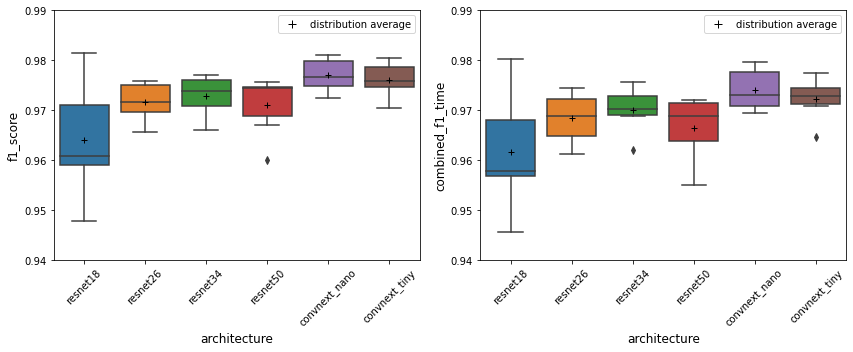

In [478]:
x_var = 'architecture'
ylim = [0.94, 0.99]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.subplot(1, 2, 1)
ax = plot_compare_v2(x_var, 'f1_score', order=arch_order, ylim=ylim)
plt.tick_params(axis='x', rotation=45)

plt.subplot(1, 2, 2)
ax = plot_compare_v2(x_var, 'combined_f1_time', order=arch_order, ylim=ylim)
plt.tick_params(axis='x', rotation=45)

fig.tight_layout()
fig.savefig('../figs/glitches/10_transfer_models_architecture')

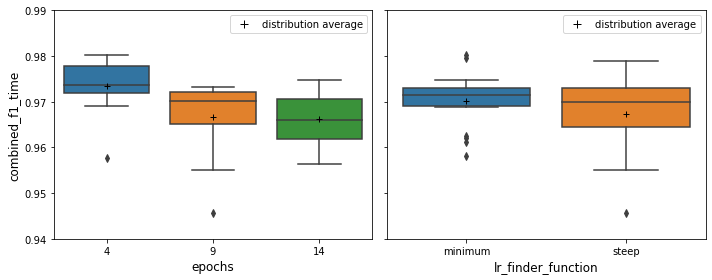

In [479]:
ylim = [0.94, 0.99]
metric = 'combined_f1_time'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

plt.subplot(1, 2, 1)
ax = plot_compare_v2('epochs', metric, ylim=ylim)

plt.subplot(1, 2, 2)
x_var = 'suggest_func'
y_order = sorted(all_df[x_var].unique())
ax = plot_compare_v2(x_var, metric, order=y_order, ylim=ylim)
ax.set_ylabel('')
ax.set_xlabel('lr_finder_function')

fig.tight_layout()
fig.savefig('../figs/glitches/10_transfer_models_epochs_lr')

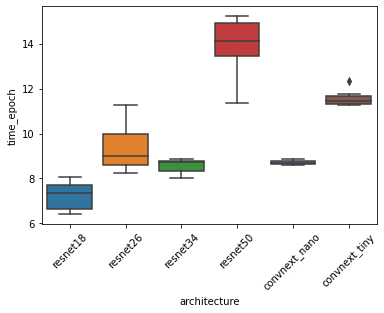

In [468]:
sns.boxplot(x='architecture', y='time_epoch', data=all_df, order=arch_order)
#sns.stripplot(x='architecture', y='time_epoch', data=all_df, linewidth=1, size=8, order=arch_order)
plt.tick_params(axis='x', rotation=45);

In [469]:
all_df.groupby('architecture').mean().sort_values(by='f1_score', ascending=False)

,epochs,frozen_epochs,f1_score,combined_f1_time,total_runtime,time_epoch
architecture,,,,,,
convnext_nano,9.0,1.0,0.976974,0.974077,86.909848,8.707223
convnext_tiny,9.0,1.0,0.976059,0.972210,115.467319,11.593992
resnet34,9.0,1.0,0.972891,0.970043,85.461456,8.544687
resnet26,9.0,1.0,0.971626,0.968417,96.276627,9.376333
resnet50,9.0,1.0,0.971036,0.966523,135.367024,13.869828
resnet18,9.0,1.0,0.963960,0.961569,71.740441,7.239364


In [470]:
all_df.groupby('suggest_func').mean().sort_values(by='f1_score', ascending=False)

,epochs,frozen_epochs,f1_score,combined_f1_time,total_runtime,time_epoch
suggest_func,,,,,,
minimum,9.0,1.0,0.973437,0.970225,96.383237,9.787403
steep,9.0,1.0,0.970744,0.967388,100.691001,9.989739


In [471]:
all_df.groupby('epochs').mean().sort_values(by='f1_score', ascending=False)

,frozen_epochs,f1_score,combined_f1_time,total_runtime,time_epoch
epochs,,,,,
4,1.0,0.975142,0.973489,49.601688,9.920338
14,1.0,0.971110,0.966255,145.667745,9.711183
9,1.0,0.970020,0.966675,100.341924,10.034192


In [472]:
all_df.sort_values(by='combined_f1_time', ascending=False)

,name,epochs,architecture,suggest_func,frozen_epochs,f1_score,combined_f1_time,total_runtime,time_epoch
34,sleek-sweep-2,4,resnet18,minimum,1,0.981457,0.980168,38.688170,7.737634
10,easy-sweep-26,4,convnext_nano,minimum,1,0.981089,0.979609,44.380975,8.876195
11,rich-sweep-25,4,convnext_nano,steep,1,0.980407,0.978971,43.077449,8.615490
5,amber-sweep-31,4,convnext_tiny,steep,1,0.979365,0.977488,56.319486,11.263897
23,brisk-sweep-13,4,resnet34,steep,1,0.977029,0.975578,43.506068,8.701214
0,morning-sweep-36,14,convnext_tiny,minimum,1,0.980437,0.974784,169.610381,11.307359
29,peachy-sweep-7,4,resnet26,steep,1,0.975788,0.974415,41.188650,8.237730
6,pleasant-sweep-30,14,convnext_nano,minimum,1,0.978180,0.973886,128.825331,8.588355
21,smart-sweep-15,9,resnet34,steep,1,0.976122,0.973214,87.223365,8.722336
4,iconic-sweep-32,4,convnext_tiny,minimum,1,0.975158,0.973099,61.764586,12.352917


In [473]:
filt = all_df['suggest_func'] != 'slide'
all_df[filt].groupby('epochs').mean().sort_values(by='f1_score', ascending=False)

,frozen_epochs,f1_score,combined_f1_time,total_runtime,time_epoch
epochs,,,,,
4,1.0,0.975142,0.973489,49.601688,9.920338
14,1.0,0.971110,0.966255,145.667745,9.711183
9,1.0,0.970020,0.966675,100.341924,10.034192


In [474]:
filt = all_df['suggest_func'] != 'slide'
all_df[filt].groupby('architecture').mean().sort_values(by='f1_score', ascending=False)

,epochs,frozen_epochs,f1_score,combined_f1_time,total_runtime,time_epoch
architecture,,,,,,
convnext_nano,9.0,1.0,0.976974,0.974077,86.909848,8.707223
convnext_tiny,9.0,1.0,0.976059,0.972210,115.467319,11.593992
resnet34,9.0,1.0,0.972891,0.970043,85.461456,8.544687
resnet26,9.0,1.0,0.971626,0.968417,96.276627,9.376333
resnet50,9.0,1.0,0.971036,0.966523,135.367024,13.869828
resnet18,9.0,1.0,0.963960,0.961569,71.740441,7.239364


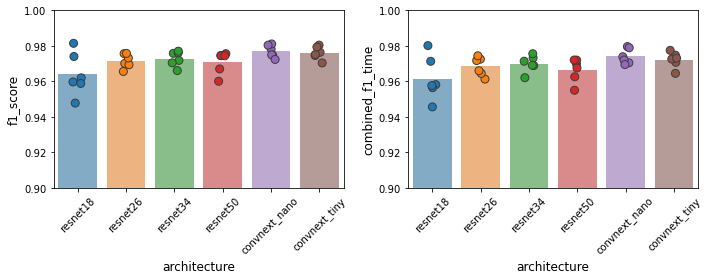

In [475]:
x_var = 'architecture'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.subplot(1, 2, 1)
ax = plot_compare(x_var, 'f1_score', order=arch_order)
plt.tick_params(axis='x', rotation=45)

plt.subplot(1, 2, 2)
ax = plot_compare(x_var, 'combined_f1_time', order=arch_order)
plt.tick_params(axis='x', rotation=45)

fig.tight_layout()
#fig.savefig('../figs/glitches/10_transfer_models_architecture')

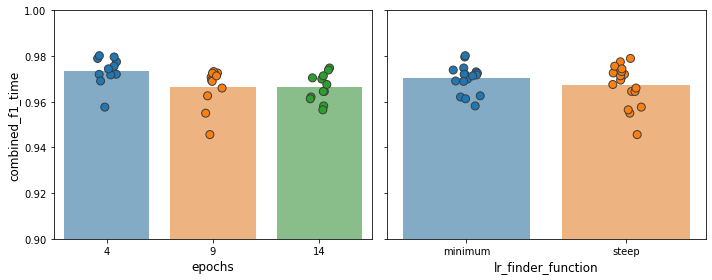

In [476]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

metric = 'combined_f1_time'
# metric = 'f1_score'

plt.subplot(1, 2, 1)
ax = plot_compare('epochs', metric)

plt.subplot(1, 2, 2)
x_var = 'suggest_func'
y_order = sorted(all_df[x_var].unique())
ax = plot_compare(x_var, metric, order=y_order)
ax.set_ylabel('')
ax.set_xlabel('lr_finder_function')

fig.tight_layout()
#fig.savefig('../figs/glitches/10_transfer_models_epochs_function')

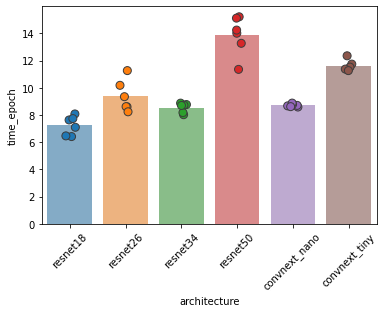

In [477]:
sns.barplot(x='architecture', y='time_epoch', data=all_df, errwidth=0, alpha=0.60, order=arch_order)
sns.stripplot(x='architecture', y='time_epoch', data=all_df, linewidth=1, size=8, order=arch_order)
plt.tick_params(axis='x', rotation=45);